In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import ldpc
import pymatching
import relay_bp

from rotated_surface_code import RotatedSurfaceCode
from decoder import BPDecoder, RelayBPDecoder
from utils import sample_error_and_syndrome, get_logical_error_rate

# Test implementation of rotated surface code

In [2]:
code = RotatedSurfaceCode(5)

In [3]:
# Check the index-to-coodinate and coordinate-to-index mappings of the data qubits and stabilizers
for j in range(code.n):
    row, col = code._dq_to_coord(j)
    assert code._coord_to_dq(row, col) == j
    print("Data qubit {} has coordinates ({}, {}).".format(j, row, col))

for i in range(code.mx):
    row, col = code._xstab_to_coord(i)
    assert code._coord_to_xstab(row, col) == i
    print("X-type stabilizer {} has coordinates ({}, {}).".format(i, row, col))

for i in range(code.mz):
    row, col = code._zstab_to_coord(i)
    assert code._coord_to_zstab(row, col) == i
    print("Z-type stabilizer {} has coordinates ({}, {}).".format(i, row, col))

Data qubit 0 has coordinates (1, 1).
Data qubit 1 has coordinates (1, 3).
Data qubit 2 has coordinates (1, 5).
Data qubit 3 has coordinates (1, 7).
Data qubit 4 has coordinates (1, 9).
Data qubit 5 has coordinates (3, 1).
Data qubit 6 has coordinates (3, 3).
Data qubit 7 has coordinates (3, 5).
Data qubit 8 has coordinates (3, 7).
Data qubit 9 has coordinates (3, 9).
Data qubit 10 has coordinates (5, 1).
Data qubit 11 has coordinates (5, 3).
Data qubit 12 has coordinates (5, 5).
Data qubit 13 has coordinates (5, 7).
Data qubit 14 has coordinates (5, 9).
Data qubit 15 has coordinates (7, 1).
Data qubit 16 has coordinates (7, 3).
Data qubit 17 has coordinates (7, 5).
Data qubit 18 has coordinates (7, 7).
Data qubit 19 has coordinates (7, 9).
Data qubit 20 has coordinates (9, 1).
Data qubit 21 has coordinates (9, 3).
Data qubit 22 has coordinates (9, 5).
Data qubit 23 has coordinates (9, 7).
Data qubit 24 has coordinates (9, 9).
X-type stabilizer 0 has coordinates (0, 2).
X-type stabilize

In [4]:
# Check the stabilizer matrices
for i in range(code.mx):
    support = code.Hx[i].nonzero()[1]
    print("X-type stabilizer {} involves data qubits {}".format(i, support))

for i in range(code.mz):
    support = code.Hz[i].nonzero()[1]
    print("Z-type stabilizer {} involves data qubits {}".format(i, support))

X-type stabilizer 0 involves data qubits [0 1]
X-type stabilizer 1 involves data qubits [2 3]
X-type stabilizer 2 involves data qubits [1 2 6 7]
X-type stabilizer 3 involves data qubits [3 4 8 9]
X-type stabilizer 4 involves data qubits [ 5  6 10 11]
X-type stabilizer 5 involves data qubits [ 7  8 12 13]
X-type stabilizer 6 involves data qubits [11 12 16 17]
X-type stabilizer 7 involves data qubits [13 14 18 19]
X-type stabilizer 8 involves data qubits [15 16 20 21]
X-type stabilizer 9 involves data qubits [17 18 22 23]
X-type stabilizer 10 involves data qubits [21 22]
X-type stabilizer 11 involves data qubits [23 24]
Z-type stabilizer 0 involves data qubits [ 5 10]
Z-type stabilizer 1 involves data qubits [0 1 5 6]
Z-type stabilizer 2 involves data qubits [ 6  7 11 12]
Z-type stabilizer 3 involves data qubits [2 3 7 8]
Z-type stabilizer 4 involves data qubits [ 8  9 13 14]
Z-type stabilizer 5 involves data qubits [4 9]
Z-type stabilizer 6 involves data qubits [15 20]
Z-type stabilizer

In [5]:
# Check the logical operators
print("Logical X operator involves data qubits {}".format(code.Lx[0].nonzero()[1]))
print("Logical Z operator involves data qubits {}".format(code.Lz[0].nonzero()[1]))

Logical X operator involves data qubits [ 0  5 10 15 20]
Logical Z operator involves data qubits [0 1 2 3 4]


In [ ]:
# Check the X-type check matrix and action matrix for the phenomenological error model with 3 rounds of stabilizer measurements
num_round = 3
cm, am, _ = code.get_check_matrix_action_matrix_probability_vector(
    'phenomenological', 'X', num_round=num_round, dq_error_rate=0.1, meas_error_rate=0.1)

def from_detector_idx_to_spacetime_coord(detector_idx):
    t, space = divmod(detector_idx, code.mx)
    x, y = code._xstab_to_coord(space)
    return x, y, t

def from_error_idx_to_spacetime_coord(error_idx):
    if error_idx < num_round * code.n:
        t, space = divmod(error_idx, code.n)
        x, y = code._dq_to_coord(space)
    else:
        t, space = divmod(error_idx - num_round * code.n, code.mx)
        x, y = code._xstab_to_coord(space)
    return x, y, t

for i in range(cm.shape[0]):
    detector_spacetime = from_detector_idx_to_spacetime_coord(i)
    errors_index = cm[i].nonzero()[1].tolist()
    errors_spacetime = [from_error_idx_to_spacetime_coord(j) for j in errors_index]
    
    print("The X-type detector at spacetime location {} detects errors at spacetime locations {}".format(
        detector_spacetime, errors_spacetime))

errors_index = am[0].nonzero()[1].tolist()
errors_spacetime = [from_error_idx_to_spacetime_coord(j) for j in errors_index]
print("The logical X operator can be flipped by errors at spacetime locations {}".format(
    errors_spacetime))

The X-type detector at spacetime location (0, 2, 0) detects errors at spacetime locations [(1, 1, 0), (1, 3, 0), (0, 2, 0)]
The X-type detector at spacetime location (0, 6, 0) detects errors at spacetime locations [(1, 5, 0), (1, 7, 0), (0, 6, 0)]
The X-type detector at spacetime location (2, 4, 0) detects errors at spacetime locations [(1, 3, 0), (1, 5, 0), (3, 3, 0), (3, 5, 0), (2, 4, 0)]
The X-type detector at spacetime location (2, 8, 0) detects errors at spacetime locations [(1, 7, 0), (1, 9, 0), (3, 7, 0), (3, 9, 0), (2, 8, 0)]
The X-type detector at spacetime location (4, 2, 0) detects errors at spacetime locations [(3, 1, 0), (3, 3, 0), (5, 1, 0), (5, 3, 0), (4, 2, 0)]
The X-type detector at spacetime location (4, 6, 0) detects errors at spacetime locations [(3, 5, 0), (3, 7, 0), (5, 5, 0), (5, 7, 0), (4, 6, 0)]
The X-type detector at spacetime location (6, 4, 0) detects errors at spacetime locations [(5, 3, 0), (5, 5, 0), (7, 3, 0), (7, 5, 0), (6, 4, 0)]
The X-type detector at

In [8]:
# Check the Z-type check matrix and action matrix for the phenomenological error model with 3 rounds of stabilizer measurements
num_round = 3
cm, am, _ = code.get_check_matrix_action_matrix_probability_vector(
    'phenomenological', 'Z', num_round=num_round, dq_error_rate=0.1, meas_error_rate=0.1)

def from_detector_idx_to_spacetime_coord(detector_idx):
    t, space = divmod(detector_idx, code.mz)
    x, y = code._zstab_to_coord(space)
    return x, y, t

def from_error_idx_to_spacetime_coord(error_idx):
    if error_idx < num_round * code.n:
        t, space = divmod(error_idx, code.n)
        x, y = code._dq_to_coord(space)
    else:
        t, space = divmod(error_idx - num_round * code.n, code.mz)
        x, y = code._zstab_to_coord(space)
    return x, y, t

for i in range(cm.shape[0]):
    detector_spacetime = from_detector_idx_to_spacetime_coord(i)
    errors_index = cm[i].nonzero()[1].tolist()
    errors_spacetime = [from_error_idx_to_spacetime_coord(j) for j in errors_index]
    
    print("The Z-type detector at spacetime location {} detects errors at spacetime locations {}".format(
        detector_spacetime, errors_spacetime))

errors_index = am[0].nonzero()[1].tolist()
errors_spacetime = [from_error_idx_to_spacetime_coord(j) for j in errors_index]
print("The logical Z operator can be flipped by errors at spacetime locations {}".format(
    errors_spacetime))

The Z-type detector at spacetime location (4, 0, 0) detects errors at spacetime locations [(3, 1, 0), (5, 1, 0), (4, 0, 0)]
The Z-type detector at spacetime location (2, 2, 0) detects errors at spacetime locations [(1, 1, 0), (1, 3, 0), (3, 1, 0), (3, 3, 0), (2, 2, 0)]
The Z-type detector at spacetime location (4, 4, 0) detects errors at spacetime locations [(3, 3, 0), (3, 5, 0), (5, 3, 0), (5, 5, 0), (4, 4, 0)]
The Z-type detector at spacetime location (2, 6, 0) detects errors at spacetime locations [(1, 5, 0), (1, 7, 0), (3, 5, 0), (3, 7, 0), (2, 6, 0)]
The Z-type detector at spacetime location (4, 8, 0) detects errors at spacetime locations [(3, 7, 0), (3, 9, 0), (5, 7, 0), (5, 9, 0), (4, 8, 0)]
The Z-type detector at spacetime location (2, 10, 0) detects errors at spacetime locations [(1, 9, 0), (3, 9, 0), (2, 10, 0)]
The Z-type detector at spacetime location (8, 0, 0) detects errors at spacetime locations [(7, 1, 0), (9, 1, 0), (8, 0, 0)]
The Z-type detector at spacetime location 

# BP decoder vs RelayBP decoder

In [ ]:
code = RotatedSurfaceCode(5)
cm, am, p = code.get_check_matrix_action_matrix_probability_vector('code-capacity', 'X', dq_error_rate=0.01)

# Define error pattern and calculate syndrome
true_error = np.zeros(code.n, dtype=np.uint8)
true_error[code._coord_to_dq(9, 1)] = 1  # Z error on the data qubit at the bottom-left corner
syndrome = (cm @ true_error) % 2

# Construct decoder
bp = BPDecoder(
    H=cm, 
    prior=p, 
    max_iter=code.n
)

num_sol=1
max_leg=5  # choice in the paper: 301
max_iter_list = [80] + [60] * (max_leg - 1)
np.random.seed(0)
mem_strength = -0.25 + 0.85 / 2 * np.random.uniform(-1, 1, size=(max_leg, code.n))
mem_strength[0, :] = 0.35
relaybp = RelayBPDecoder(
    H=cm,
    prior=p,
    num_sol=num_sol,
    max_leg=max_leg,
    mem_strength=mem_strength,
    max_iter_list=max_iter_list
)

# Decode
decoded_error_bp = bp.decode(syndrome)
decoded_error_relaybp = relaybp.decode(syndrome)

# Print the result
residual_error_bp = (decoded_error_bp + true_error) % 2
residual_syndrome_bp = (cm @ residual_error_bp) % 2
residual_action_bp = (am @ residual_error_bp) % 2
print("Has the BP decoder decoded the error correctly? {}".format(
    np.all(residual_syndrome_bp == 0) and np.all(residual_action_bp == 0)))

residual_error_relaybp = (decoded_error_relaybp + true_error) % 2
residual_syndrome_relaybp = (cm @ residual_error_relaybp) % 2
residual_action_relaybp = (am @ residual_error_relaybp) % 2
print("Has the RelayBP decoder decoded the error correctly? {}".format(
    np.all(residual_syndrome_relaybp == 0) and np.all(residual_action_relaybp == 0)))

Has the BP decoder decoded the error correctly? False
Has the RelayBP decoder decoded the error correctly? True


# Monte Carlo simulation under code-capacity noise model

#### MWPM decoder (from `pymatching` package)

In [2]:
N = 3000 # number of samples

d_list = list(range(5, 14, 4)) # code distance
per_list = np.linspace(0.01, 0.2, 20).tolist() # physical error rate
ler_array = np.zeros((len(d_list), len(per_list))) # logical error rate

for i, d in enumerate(d_list):
    # Construct the code
    code = RotatedSurfaceCode(d)

    for j, per in enumerate(per_list):
        # Get check matrix, action matrix, and probability vector. We focus on X-type stabilizers.
        cm, am, p = code.get_check_matrix_action_matrix_probability_vector('code-capacity', 'X', dq_error_rate=per)
        # Sample error patterns and calculate syndromes
        true_error, syndrome = sample_error_and_syndrome(cm, p, N, seed=42)
        # Construct decoder
        matching = pymatching.Matching.from_check_matrix(cm, weights=np.log((1 - p) / p))
        # Decode
        decoded_error = matching.decode_batch(syndrome)
        # Calculate logical error rate
        ler = get_logical_error_rate(cm, am, true_error, decoded_error)
        # Store the result
        ler_array[i, j] = ler


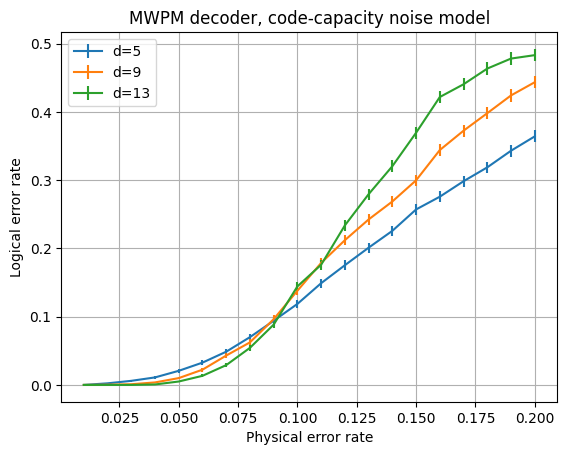

In [3]:
plt.figure()
for i, d in enumerate(d_list):
    ler = ler_array[i]
    std_err = (ler * (1 - ler) / N) ** 0.5
    plt.errorbar(per_list, ler, yerr=std_err, label="d={}".format(d))
plt.xlabel("Physical error rate")
plt.ylabel("Logical error rate")
plt.grid(True)
plt.legend()
plt.title("MWPM decoder, code-capacity noise model")
plt.show()

#### BP+OSD decoder (from `ldpc` package)

In [4]:
N = 3000 # number of samples

d_list = list(range(5, 14, 4)) # code distance
per_list = np.linspace(0.01, 0.2, 9).tolist() # physical error rate
ler_array = np.zeros((len(d_list), len(per_list))) # logical error rate

for i, d in enumerate(d_list):
    # Construct the code
    code = RotatedSurfaceCode(d)

    for j, per in enumerate(per_list):
        # Get check matrix, action matrix, and probability vector. We focus on X-type stabilizers.
        cm, am, p = code.get_check_matrix_action_matrix_probability_vector('code-capacity', 'X', dq_error_rate=per)
        # Sample error patterns and calculate syndromes
        true_error, syndrome = sample_error_and_syndrome(cm, p, N, seed=42)
        # Construct decoder
        decoder = ldpc.BpOsdDecoder(
            pcm=cm,
            error_channel=p.tolist(),
            bp_method='minimum_sum',
            max_iter=len(p),
            schedule='parallel', # 'serial'
            osd_method='osd_cs',
            osd_order=2
        )
        # Decode
        decoded_error = []
        for ii in range(N):
            decoded_error.append(decoder.decode(syndrome[ii]))
        decoded_error = np.array(decoded_error, dtype=np.uint8)
        # Calculate logical error rate
        ler = get_logical_error_rate(cm, am, true_error, decoded_error)
        # Store the result
        ler_array[i, j] = ler

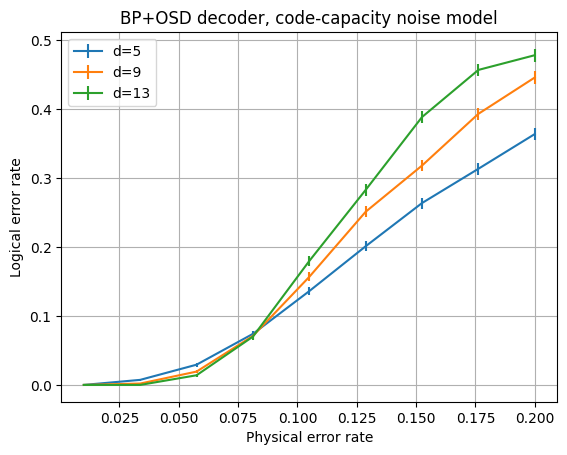

In [5]:
plt.figure()
for i, d in enumerate(d_list):
    ler = ler_array[i]
    std_err = (ler * (1 - ler) / N) ** 0.5
    plt.errorbar(per_list, ler, yerr=std_err, label="d={}".format(d))
plt.xlabel("Physical error rate")
plt.ylabel("Logical error rate")
plt.grid(True)
plt.legend()
plt.title("BP+OSD decoder, code-capacity noise model")
plt.show()

#### BP decoder (from `ldpc` package)

In [16]:
N = 1000 # number of samples

d_list = list(range(5, 10, 2)) # code distance
per_list = np.linspace(0.001, 0.1, 9).tolist() # physical error rate
ler_array = np.zeros((len(d_list), len(per_list))) # logical error rate

for i, d in enumerate(d_list):
    # Construct the code
    code = RotatedSurfaceCode(d)

    for j, per in enumerate(per_list):
        # Get check matrix, action matrix, and probability vector. We focus on X-type stabilizers.
        cm, am, p = code.get_check_matrix_action_matrix_probability_vector('code-capacity', 'X', dq_error_rate=per)
        # Sample error patterns and calculate syndromes
        true_error, syndrome = sample_error_and_syndrome(cm, p, N, seed=42)
        # Construct decoder
        decoder = ldpc.BpDecoder(
            pcm=cm,
            error_channel=p.tolist(),
            bp_method='minimum_sum',
            max_iter=len(p),
            schedule='parallel', # 'serial'
        )
        # Decode
        decoded_error = []
        for ii in range(N):
            decoded_error.append(decoder.decode(syndrome[ii]))
        decoded_error = np.array(decoded_error, dtype=np.uint8)
        # Calculate logical error rate
        ler = get_logical_error_rate(cm, am, true_error, decoded_error)
        # Store the result
        ler_array[i, j] = ler

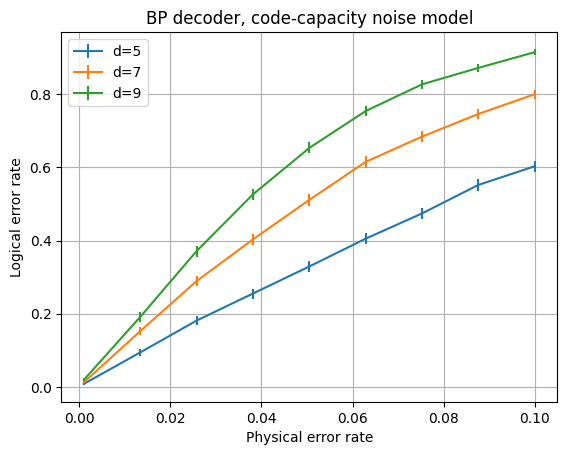

In [17]:
plt.figure()
for i, d in enumerate(d_list):
    ler = ler_array[i]
    std_err = (ler * (1 - ler) / N) ** 0.5
    plt.errorbar(per_list, ler, yerr=std_err, label="d={}".format(d))
plt.xlabel("Physical error rate")
plt.ylabel("Logical error rate")
plt.grid(True)
plt.legend()
plt.title("BP decoder, code-capacity noise model")
plt.show()

#### BP decoder (my implementation)

In [5]:
N = 1000 # number of samples

d_list = list(range(5, 10, 2)) # code distance
per_list = np.linspace(0.001, 0.1, 9).tolist() # physical error rate
ler_array = np.zeros((len(d_list), len(per_list))) # logical error rate

for i, d in enumerate(d_list):
    # Construct the code
    code = RotatedSurfaceCode(d)

    for j, per in enumerate(per_list):
        # Get check matrix, action matrix, and probability vector. We focus on X-type stabilizers.
        cm, am, p = code.get_check_matrix_action_matrix_probability_vector('code-capacity', 'X', dq_error_rate=per)
        # Sample error patterns and calculate syndromes
        true_error, syndrome = sample_error_and_syndrome(cm, p, N, seed=42)
        # Construct decoder
        decoder = BPDecoder(cm, p, max_iter=len(p))
        # Decode
        decoded_error = decoder.decode_batch(syndrome)
        # Calculate logical error rate
        ler = get_logical_error_rate(cm, am, true_error, decoded_error)
        # Store the result
        ler_array[i, j] = ler

        print(f"d={d}, per={per}, ler={ler}")

100%|██████████| 1000/1000 [00:00<00:00, 1418.57it/s]


d=5, per=0.001, ler=0.008


100%|██████████| 1000/1000 [00:01<00:00, 893.80it/s]


d=5, per=0.013375000000000001, ler=0.095


100%|██████████| 1000/1000 [00:01<00:00, 564.29it/s]


d=5, per=0.025750000000000002, ler=0.183


100%|██████████| 1000/1000 [00:02<00:00, 400.61it/s]


d=5, per=0.038125000000000006, ler=0.26


100%|██████████| 1000/1000 [00:03<00:00, 269.80it/s]


d=5, per=0.0505, ler=0.34


100%|██████████| 1000/1000 [00:04<00:00, 234.56it/s]


d=5, per=0.062875, ler=0.417


100%|██████████| 1000/1000 [00:04<00:00, 239.88it/s]


d=5, per=0.07525000000000001, ler=0.488


100%|██████████| 1000/1000 [00:04<00:00, 222.99it/s]


d=5, per=0.08762500000000001, ler=0.566


100%|██████████| 1000/1000 [00:05<00:00, 195.68it/s]


d=5, per=0.1, ler=0.618


100%|██████████| 1000/1000 [00:01<00:00, 975.88it/s]


d=7, per=0.001, ler=0.012


100%|██████████| 1000/1000 [00:05<00:00, 188.60it/s]


d=7, per=0.013375000000000001, ler=0.152


100%|██████████| 1000/1000 [00:09<00:00, 105.41it/s]


d=7, per=0.025750000000000002, ler=0.291


100%|██████████| 1000/1000 [00:13<00:00, 74.74it/s]


d=7, per=0.038125000000000006, ler=0.406


100%|██████████| 1000/1000 [00:16<00:00, 59.08it/s]


d=7, per=0.0505, ler=0.528


100%|██████████| 1000/1000 [00:19<00:00, 51.44it/s]


d=7, per=0.062875, ler=0.632


100%|██████████| 1000/1000 [00:21<00:00, 46.18it/s]


d=7, per=0.07525000000000001, ler=0.705


100%|██████████| 1000/1000 [00:23<00:00, 42.93it/s]


d=7, per=0.08762500000000001, ler=0.766


100%|██████████| 1000/1000 [00:25<00:00, 39.80it/s]


d=7, per=0.1, ler=0.818


100%|██████████| 1000/1000 [00:02<00:00, 368.05it/s]


d=9, per=0.001, ler=0.019


100%|██████████| 1000/1000 [00:18<00:00, 54.79it/s]


d=9, per=0.013375000000000001, ler=0.194


100%|██████████| 1000/1000 [00:33<00:00, 29.59it/s]


d=9, per=0.025750000000000002, ler=0.383


100%|██████████| 1000/1000 [00:46<00:00, 21.49it/s]


d=9, per=0.038125000000000006, ler=0.535


100%|██████████| 1000/1000 [00:58<00:00, 17.19it/s]


d=9, per=0.0505, ler=0.668


100%|██████████| 1000/1000 [01:10<00:00, 14.20it/s]


d=9, per=0.062875, ler=0.773


100%|██████████| 1000/1000 [01:18<00:00, 12.82it/s]


d=9, per=0.07525000000000001, ler=0.846


100%|██████████| 1000/1000 [01:20<00:00, 12.37it/s]


d=9, per=0.08762500000000001, ler=0.884


100%|██████████| 1000/1000 [01:21<00:00, 12.35it/s]

d=9, per=0.1, ler=0.925


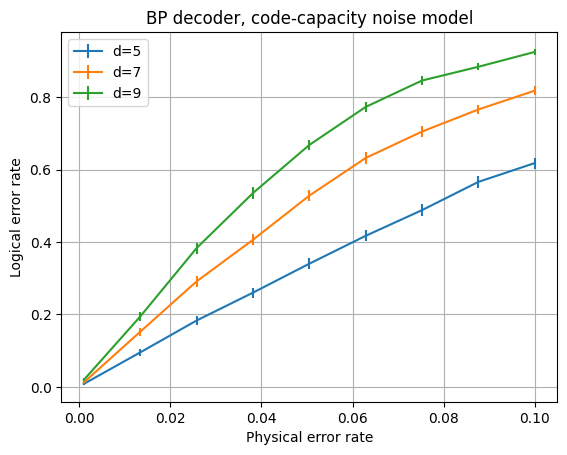

In [6]:
plt.figure()
for i, d in enumerate(d_list):
    ler = ler_array[i]
    std_err = (ler * (1 - ler) / N) ** 0.5
    plt.errorbar(per_list, ler, yerr=std_err, label="d={}".format(d))
plt.xlabel("Physical error rate")
plt.ylabel("Logical error rate")
plt.grid(True)
plt.legend()
plt.title("BP decoder, code-capacity noise model")
plt.show()

#### Relay-BP decoder (from `relay_bp`)

In [23]:
N = 1000 # number of samples

d_list = list(range(5, 10, 2)) # code distance
per_list = np.linspace(0.001, 0.1, 9).tolist() # physical error rate
ler_array = np.zeros((len(d_list), len(per_list))) # logical error rate

for i, d in enumerate(d_list):
    # Construct the code
    code = RotatedSurfaceCode(d)

    for j, per in enumerate(per_list):
        # Get check matrix, action matrix, and probability vector. We focus on X-type stabilizers.
        cm, am, p = code.get_check_matrix_action_matrix_probability_vector('code-capacity', 'X', dq_error_rate=per)
        # Sample error patterns and calculate syndromes
        true_error, syndrome = sample_error_and_syndrome(cm, p, N, seed=42)
        # Construct decoder
        decoder = relay_bp.RelayDecoderF32(
            cm,                                   
            error_priors=p,
            gamma0=0.1,
            pre_iter=80,
            num_sets=5,
            set_max_iter=60,
            gamma_dist_interval=(-0.24, 0.66),
            stop_nconv=1,
        )
        # Decode
        decoded_error = decoder.decode_batch(syndrome)
        # Calculate logical error rate
        ler = get_logical_error_rate(cm, am, true_error, decoded_error)
        # Store the result
        ler_array[i, j] = ler

        print(f"d={d}, per={per}, ler={ler}")


d=5, per=0.001, ler=0.0
d=5, per=0.013375000000000001, ler=0.003
d=5, per=0.025750000000000002, ler=0.008
d=5, per=0.038125000000000006, ler=0.019
d=5, per=0.0505, ler=0.024
d=5, per=0.062875, ler=0.047
d=5, per=0.07525000000000001, ler=0.061
d=5, per=0.08762500000000001, ler=0.091
d=5, per=0.1, ler=0.126
d=7, per=0.001, ler=0.0
d=7, per=0.013375000000000001, ler=0.0
d=7, per=0.025750000000000002, ler=0.004
d=7, per=0.038125000000000006, ler=0.008
d=7, per=0.0505, ler=0.024
d=7, per=0.062875, ler=0.063
d=7, per=0.07525000000000001, ler=0.073
d=7, per=0.08762500000000001, ler=0.121
d=7, per=0.1, ler=0.153
d=9, per=0.001, ler=0.0
d=9, per=0.013375000000000001, ler=0.0
d=9, per=0.025750000000000002, ler=0.005
d=9, per=0.038125000000000006, ler=0.011
d=9, per=0.0505, ler=0.023
d=9, per=0.062875, ler=0.05
d=9, per=0.07525000000000001, ler=0.079
d=9, per=0.08762500000000001, ler=0.127
d=9, per=0.1, ler=0.186


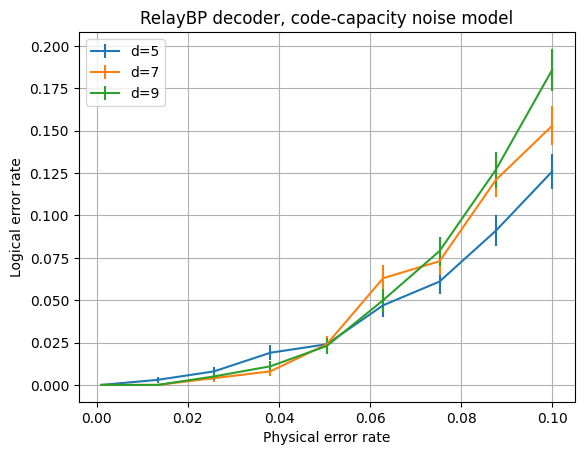

In [24]:
plt.figure()
for i, d in enumerate(d_list):
    ler = ler_array[i]
    std_err = (ler * (1 - ler) / N) ** 0.5
    plt.errorbar(per_list, ler, yerr=std_err, label="d={}".format(d))
plt.xlabel("Physical error rate")
plt.ylabel("Logical error rate")
plt.grid(True)
plt.legend()
plt.title("RelayBP decoder, code-capacity noise model")
plt.show()

#### Relay-BP decoder (my implementation)

In [19]:
N = 1000 # number of samples

d_list = list(range(5, 10, 2)) # code distance
per_list = np.linspace(0.001, 0.1, 9).tolist() # physical error rate
ler_array = np.zeros((len(d_list), len(per_list))) # logical error rate

for i, d in enumerate(d_list):
    # Construct the code
    code = RotatedSurfaceCode(d)

    for j, per in enumerate(per_list):
        # Get check matrix, action matrix, and probability vector. We focus on X-type stabilizers.
        cm, am, p = code.get_check_matrix_action_matrix_probability_vector('code-capacity', 'X', dq_error_rate=per)
        # Sample error patterns and calculate syndromes
        true_error, syndrome = sample_error_and_syndrome(cm, p, N, seed=42)
        # Construct decoder
        num_sol=1
        max_leg=5  # choice in the paper: 301
        max_iter_list = [80] + [60] * (max_leg - 1)
        np.random.seed(0)
        mem_strength = np.random.uniform(-0.24, 0.66, size=(max_leg, len(p)))
        mem_strength[0, :] = 0.1
        decoder = RelayBPDecoder(
            H=cm,
            prior=p,
            num_sol=num_sol,
            max_leg=max_leg,
            mem_strength=mem_strength,
            max_iter_list=max_iter_list
        )
        # Decode
        decoded_error = decoder.decode_batch(syndrome)
        # Calculate logical error rate
        ler = get_logical_error_rate(cm, am, true_error, decoded_error)
        # Store the result
        ler_array[i, j] = ler

        print(f"d={d}, per={per}, ler={ler}")

100%|██████████| 1000/1000 [00:00<00:00, 1839.31it/s]


d=5, per=0.001, ler=0.0


100%|██████████| 1000/1000 [00:02<00:00, 357.35it/s]


d=5, per=0.013375000000000001, ler=0.001


100%|██████████| 1000/1000 [00:05<00:00, 198.90it/s]


d=5, per=0.025750000000000002, ler=0.006


100%|██████████| 1000/1000 [00:06<00:00, 147.97it/s]


d=5, per=0.038125000000000006, ler=0.012


100%|██████████| 1000/1000 [00:08<00:00, 115.36it/s]


d=5, per=0.0505, ler=0.016


100%|██████████| 1000/1000 [00:10<00:00, 95.29it/s]


d=5, per=0.062875, ler=0.032


100%|██████████| 1000/1000 [00:12<00:00, 82.87it/s]


d=5, per=0.07525000000000001, ler=0.042


100%|██████████| 1000/1000 [00:13<00:00, 73.77it/s]


d=5, per=0.08762500000000001, ler=0.074


100%|██████████| 1000/1000 [00:15<00:00, 62.73it/s]


d=5, per=0.1, ler=0.102


100%|██████████| 1000/1000 [00:01<00:00, 769.81it/s]


d=7, per=0.001, ler=0.0


100%|██████████| 1000/1000 [00:08<00:00, 112.01it/s]


d=7, per=0.013375000000000001, ler=0.0


100%|██████████| 1000/1000 [00:15<00:00, 63.03it/s]


d=7, per=0.025750000000000002, ler=0.003


100%|██████████| 1000/1000 [00:22<00:00, 45.33it/s]


d=7, per=0.038125000000000006, ler=0.008


100%|██████████| 1000/1000 [00:27<00:00, 36.15it/s]


d=7, per=0.0505, ler=0.019


100%|██████████| 1000/1000 [00:32<00:00, 30.44it/s]


d=7, per=0.062875, ler=0.042


100%|██████████| 1000/1000 [00:36<00:00, 27.18it/s]


d=7, per=0.07525000000000001, ler=0.07


100%|██████████| 1000/1000 [00:40<00:00, 24.50it/s]


d=7, per=0.08762500000000001, ler=0.105


100%|██████████| 1000/1000 [00:43<00:00, 22.74it/s]


d=7, per=0.1, ler=0.149


100%|██████████| 1000/1000 [00:02<00:00, 359.48it/s]


d=9, per=0.001, ler=0.0


100%|██████████| 1000/1000 [00:19<00:00, 51.08it/s]


d=9, per=0.013375000000000001, ler=0.0


100%|██████████| 1000/1000 [00:38<00:00, 26.09it/s]


d=9, per=0.025750000000000002, ler=0.005


100%|██████████| 1000/1000 [00:51<00:00, 19.44it/s]


d=9, per=0.038125000000000006, ler=0.01


100%|██████████| 1000/1000 [01:03<00:00, 15.66it/s]


d=9, per=0.0505, ler=0.017


100%|██████████| 1000/1000 [01:18<00:00, 12.76it/s]


d=9, per=0.062875, ler=0.041


100%|██████████| 1000/1000 [01:29<00:00, 11.16it/s]


d=9, per=0.07525000000000001, ler=0.074


100%|██████████| 1000/1000 [01:34<00:00, 10.58it/s]


d=9, per=0.08762500000000001, ler=0.12


100%|██████████| 1000/1000 [01:42<00:00,  9.71it/s]


d=9, per=0.1, ler=0.172


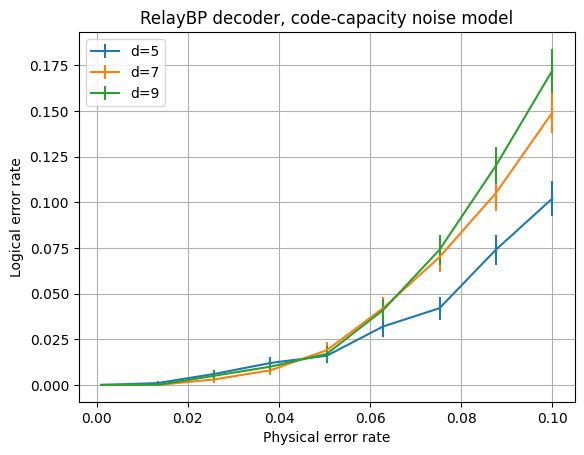

In [20]:
plt.figure()
for i, d in enumerate(d_list):
    ler = ler_array[i]
    std_err = (ler * (1 - ler) / N) ** 0.5
    plt.errorbar(per_list, ler, yerr=std_err, label="d={}".format(d))
plt.xlabel("Physical error rate")
plt.ylabel("Logical error rate")
plt.grid(True)
plt.legend()
plt.title("RelayBP decoder, code-capacity noise model")
plt.show()

# Monte Carlo simulation under phenomenological noise model

#### MWPM decoder (from `pymatching` package)

In [10]:
N = 3000 # number of samples

d_list = list(range(5, 10, 2)) # code distance
per_list = np.linspace(0.02, 0.04, 7).tolist() # physical error rate
ler_array = np.zeros((len(d_list), len(per_list))) # logical error rate

for i, d in enumerate(d_list):
    # Construct the code
    code = RotatedSurfaceCode(d)

    for j, per in enumerate(per_list):
        # Get check matrix, action matrix, and probability vector. We focus on X-type stabilizers.
        cm, am, p = code.get_check_matrix_action_matrix_probability_vector('phenomenological', 'X', num_round=d,
                                                                           dq_error_rate=per, meas_error_rate=per)
        # Sample error patterns and calculate syndromes
        true_error, syndrome = sample_error_and_syndrome(cm, p, N, seed=42)
        # Construct decoder
        decoder = pymatching.Matching.from_check_matrix(cm, weights=np.log((1 - p) / p))
        # Decode
        decoded_error = decoder.decode_batch(syndrome)
        # Calculate logical error rate
        ler = get_logical_error_rate(cm, am, true_error, decoded_error)
        # Store the result
        ler_array[i, j] = ler

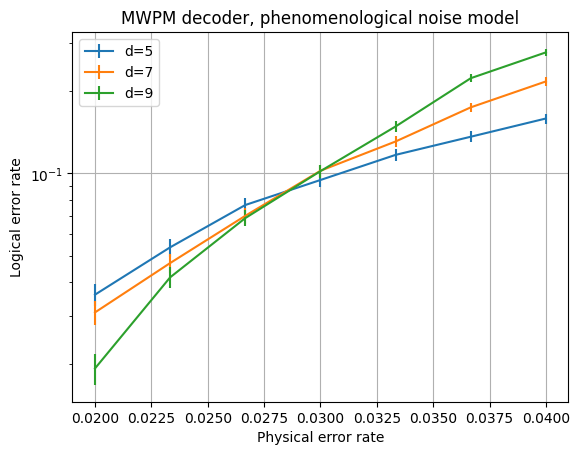

In [11]:
plt.figure()
for i, d in enumerate(d_list):
    ler = ler_array[i]
    std_err = (ler * (1 - ler) / N) ** 0.5
    plt.errorbar(per_list, ler, yerr=std_err, label="d={}".format(d))
plt.xlabel("Physical error rate")
plt.ylabel("Logical error rate")
plt.yscale('log')
plt.grid(True)
plt.legend()
plt.title("MWPM decoder, phenomenological noise model")
plt.show()

#### BP+OSD decoder (from `ldpc` package)

In [14]:
N = 3000 # number of samples

d_list = list(range(5, 10, 2)) # code distance
per_list = np.linspace(0.01, 0.04, 7).tolist() # physical error rate
ler_array = np.zeros((len(d_list), len(per_list))) # logical error rate

for i, d in enumerate(d_list):
    # Construct the code
    code = RotatedSurfaceCode(d)

    for j, per in enumerate(per_list):
        # Get check matrix, action matrix, and probability vector. We focus on X-type stabilizers.
        cm, am, p = code.get_check_matrix_action_matrix_probability_vector('phenomenological', 'X', num_round=d,
                                                                           dq_error_rate=per, meas_error_rate=per)
        # Sample error patterns and calculate syndromes
        true_error, syndrome = sample_error_and_syndrome(cm, p, N, seed=42)
        # Construct decoder
        decoder = ldpc.BpOsdDecoder(
            pcm=cm,
            error_channel=p.tolist(),
            bp_method='minimum_sum',
            max_iter=len(p),
            schedule='parallel', # 'serial'
            osd_method='osd_cs',
            osd_order=2
        )
        # Decode
        decoded_error = []
        for ii in tqdm(range(N)):
            decoded_error.append(decoder.decode(syndrome[ii]))
        decoded_error = np.array(decoded_error, dtype=np.uint8)
        # Calculate logical error rate
        ler = get_logical_error_rate(cm, am, true_error, decoded_error)
        # Store the result
        ler_array[i, j] = ler

        print("d={}, per={}, ler={}".format(d, per, ler))


100%|██████████| 3000/3000 [00:00<00:00, 7801.75it/s]


d=5, per=0.01, ler=0.006666666666666667


100%|██████████| 3000/3000 [00:00<00:00, 4155.81it/s]


d=5, per=0.015, ler=0.018


100%|██████████| 3000/3000 [00:00<00:00, 4846.21it/s]


d=5, per=0.02, ler=0.03266666666666666


100%|██████████| 3000/3000 [00:00<00:00, 4196.08it/s]


d=5, per=0.025, ler=0.06133333333333333


100%|██████████| 3000/3000 [00:00<00:00, 3819.91it/s]


d=5, per=0.03, ler=0.08866666666666667


100%|██████████| 3000/3000 [00:00<00:00, 3525.72it/s]


d=5, per=0.035, ler=0.128


100%|██████████| 3000/3000 [00:00<00:00, 3356.08it/s]


d=5, per=0.04, ler=0.168


100%|██████████| 3000/3000 [00:05<00:00, 569.68it/s]


d=7, per=0.01, ler=0.0016666666666666668


100%|██████████| 3000/3000 [00:06<00:00, 446.06it/s]


d=7, per=0.015, ler=0.012666666666666666


100%|██████████| 3000/3000 [00:07<00:00, 407.24it/s]


d=7, per=0.02, ler=0.029


100%|██████████| 3000/3000 [00:08<00:00, 369.75it/s]


d=7, per=0.025, ler=0.060333333333333336


100%|██████████| 3000/3000 [00:08<00:00, 361.93it/s]


d=7, per=0.03, ler=0.109


100%|██████████| 3000/3000 [00:08<00:00, 353.78it/s]


d=7, per=0.035, ler=0.16033333333333333


100%|██████████| 3000/3000 [00:08<00:00, 349.69it/s]


d=7, per=0.04, ler=0.229


100%|██████████| 3000/3000 [00:46<00:00, 64.22it/s]


d=9, per=0.01, ler=0.0013333333333333333


100%|██████████| 3000/3000 [00:49<00:00, 60.93it/s]


d=9, per=0.015, ler=0.008666666666666666


100%|██████████| 3000/3000 [00:51<00:00, 58.18it/s]


d=9, per=0.02, ler=0.025666666666666667


100%|██████████| 3000/3000 [00:53<00:00, 55.80it/s]


d=9, per=0.025, ler=0.06633333333333333


100%|██████████| 3000/3000 [00:54<00:00, 55.10it/s]


d=9, per=0.03, ler=0.12033333333333333


100%|██████████| 3000/3000 [00:54<00:00, 55.15it/s]


d=9, per=0.035, ler=0.195


100%|██████████| 3000/3000 [00:56<00:00, 53.25it/s]


d=9, per=0.04, ler=0.2966666666666667


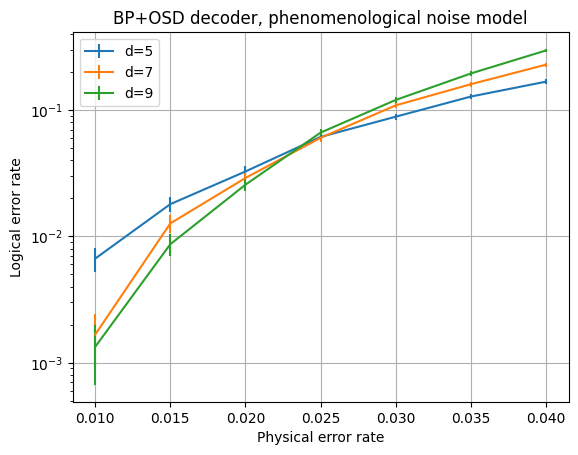

In [15]:
plt.figure()
for i, d in enumerate(d_list):
    ler = ler_array[i]
    std_err = (ler * (1 - ler) / N) ** 0.5
    plt.errorbar(per_list, ler, yerr=std_err, label="d={}".format(d))
plt.xlabel("Physical error rate")
plt.ylabel("Logical error rate")
plt.yscale('log')
plt.grid(True)
plt.legend()
plt.title("BP+OSD decoder, phenomenological noise model")
plt.show()

#### BP decoder (from `ldpc` package)

In [9]:
N = 3000 # number of samples

d_list = list(range(5, 10, 2)) # code distance
per_list = np.linspace(0.01, 0.04, 7).tolist() # physical error rate
ler_array = np.zeros((len(d_list), len(per_list))) # logical error rate

for i, d in enumerate(d_list):
    # Construct the code
    code = RotatedSurfaceCode(d)

    for j, per in enumerate(per_list):
        # Get check matrix, action matrix, and probability vector. We focus on X-type stabilizers.
        cm, am, p = code.get_check_matrix_action_matrix_probability_vector('phenomenological', 'X', num_round=d,
                                                                           dq_error_rate=per, meas_error_rate=per)
        # Sample error patterns and calculate syndromes
        true_error, syndrome = sample_error_and_syndrome(cm, p, N, seed=42)
        # Construct decoder
        decoder = ldpc.BpDecoder(
            pcm=cm,
            error_channel=p.tolist(),
            bp_method='minimum_sum',
            max_iter=len(p),
            schedule='parallel', # 'serial'
        )
        # Decode
        decoded_error = []
        for ii in range(N):
            decoded_error.append(decoder.decode(syndrome[ii]))
        decoded_error = np.array(decoded_error, dtype=np.uint8)
        # Calculate logical error rate
        ler = get_logical_error_rate(cm, am, true_error, decoded_error)
        # Store the result
        ler_array[i, j] = ler

        print("d={}, per={}, ler={}".format(d, per, ler))


d=5, per=0.01, ler=0.347
d=5, per=0.015, ler=0.48833333333333334
d=5, per=0.02, ler=0.5936666666666667
d=5, per=0.025, ler=0.6916666666666667
d=5, per=0.03, ler=0.7633333333333333
d=5, per=0.035, ler=0.819
d=5, per=0.04, ler=0.8613333333333333
d=7, per=0.01, ler=0.6076666666666667
d=7, per=0.015, ler=0.784
d=7, per=0.02, ler=0.8756666666666667
d=7, per=0.025, ler=0.9363333333333334
d=7, per=0.03, ler=0.9703333333333334
d=7, per=0.035, ler=0.9853333333333333
d=7, per=0.04, ler=0.9916666666666667
d=9, per=0.01, ler=0.8193333333333334
d=9, per=0.015, ler=0.943
d=9, per=0.02, ler=0.9863333333333333
d=9, per=0.025, ler=0.994
d=9, per=0.03, ler=0.999
d=9, per=0.035, ler=1.0
d=9, per=0.04, ler=1.0


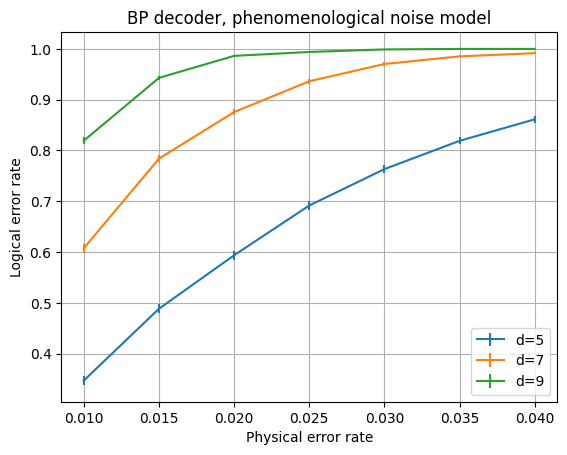

In [11]:
plt.figure()
for i, d in enumerate(d_list):
    ler = ler_array[i]
    std_err = (ler * (1 - ler) / N) ** 0.5
    plt.errorbar(per_list, ler, yerr=std_err, label="d={}".format(d))
plt.xlabel("Physical error rate")
plt.ylabel("Logical error rate")
plt.grid(True)
plt.legend()
plt.title("BP decoder, phenomenological noise model")
plt.show()

# Tuning parameters for the RelayBP decoder

d=5, per=0.001, ler=0.0
d=5, per=0.011473684210526316, ler=0.0003333333333333333
d=5, per=0.021947368421052632, ler=0.0026666666666666666
d=5, per=0.03242105263157895, ler=0.006666666666666667
d=5, per=0.04289473684210526, ler=0.013666666666666667
d=5, per=0.05336842105263158, ler=0.024333333333333332
d=5, per=0.0638421052631579, ler=0.03866666666666667
d=5, per=0.07431578947368421, ler=0.05566666666666667
d=5, per=0.08478947368421053, ler=0.08066666666666666
d=5, per=0.09526315789473684, ler=0.10866666666666666
d=5, per=0.10573684210526316, ler=0.13966666666666666
d=5, per=0.11621052631578947, ler=0.16633333333333333
d=5, per=0.1266842105263158, ler=0.195
d=5, per=0.1371578947368421, ler=0.221
d=5, per=0.14763157894736842, ler=0.25066666666666665
d=5, per=0.15810526315789475, ler=0.272
d=5, per=0.16857894736842105, ler=0.2946666666666667
d=5, per=0.17905263157894735, ler=0.31566666666666665
d=5, per=0.18952631578947368, ler=0.3436666666666667
d=5, per=0.2, ler=0.36433333333333334
d=9,

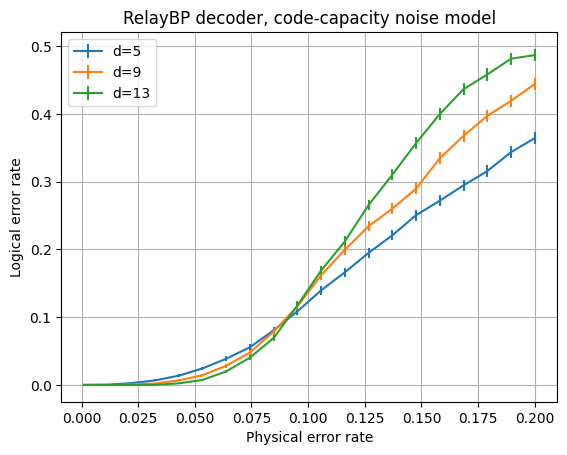

In [17]:
N = 3000 # number of samples

d_list = list(range(5, 14, 4)) # code distance
per_list = np.linspace(0.001, 0.2, 20).tolist() # physical error rate
ler_array = np.zeros((len(d_list), len(per_list))) # logical error rate

for i, d in enumerate(d_list):
    # Construct the code
    code = RotatedSurfaceCode(d)

    for j, per in enumerate(per_list):
        # Get check matrix, action matrix, and probability vector. We focus on X-type stabilizers.
        cm, am, p = code.get_check_matrix_action_matrix_probability_vector('code-capacity', 'X', dq_error_rate=per)
        # Sample error patterns and calculate syndromes
        true_error, syndrome = sample_error_and_syndrome(cm, p, N, seed=42)
        # Construct decoder
        decoder = relay_bp.RelayDecoderF32(
            cm,                                   
            error_priors=p,
            gamma0=0.1,
            pre_iter=80,
            num_sets=100,
            set_max_iter=60,
            gamma_dist_interval=(-0.24, 0.66),
            stop_nconv=5,
        )
        # Decode
        decoded_error = decoder.decode_batch(syndrome)
        # Calculate logical error rate
        ler = get_logical_error_rate(cm, am, true_error, decoded_error)
        # Store the result
        ler_array[i, j] = ler

        print(f"d={d}, per={per}, ler={ler}")

plt.figure()
for i, d in enumerate(d_list):
    ler = ler_array[i]
    std_err = (ler * (1 - ler) / N) ** 0.5
    plt.errorbar(per_list, ler, yerr=std_err, label="d={}".format(d))
plt.xlabel("Physical error rate")
plt.ylabel("Logical error rate")
plt.grid(True)
plt.legend()
plt.title("RelayBP decoder, code-capacity noise model")
plt.show()

d=5, per=0.001, ler=0.0
d=5, per=0.011473684210526316, ler=0.0003333333333333333
d=5, per=0.021947368421052632, ler=0.003
d=5, per=0.03242105263157895, ler=0.007
d=5, per=0.04289473684210526, ler=0.014333333333333333
d=5, per=0.05336842105263158, ler=0.028333333333333332
d=5, per=0.0638421052631579, ler=0.04133333333333333
d=5, per=0.07431578947368421, ler=0.06
d=5, per=0.08478947368421053, ler=0.08533333333333333
d=5, per=0.09526315789473684, ler=0.11333333333333333
d=5, per=0.10573684210526316, ler=0.14433333333333334
d=5, per=0.11621052631578947, ler=0.17333333333333334
d=5, per=0.1266842105263158, ler=0.20466666666666666
d=5, per=0.1371578947368421, ler=0.22866666666666666
d=5, per=0.14763157894736842, ler=0.25966666666666666
d=5, per=0.15810526315789475, ler=0.2816666666666667
d=5, per=0.16857894736842105, ler=0.30233333333333334
d=5, per=0.17905263157894735, ler=0.3243333333333333
d=5, per=0.18952631578947368, ler=0.351
d=5, per=0.2, ler=0.37266666666666665
d=9, per=0.001, ler=0.

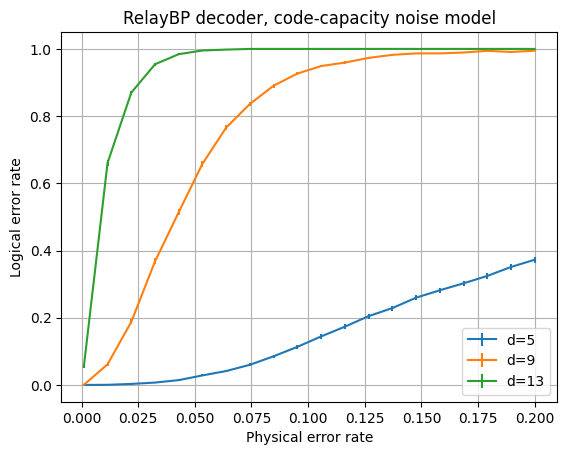

In [18]:
N = 3000 # number of samples

d_list = list(range(5, 14, 4)) # code distance
per_list = np.linspace(0.001, 0.2, 20).tolist() # physical error rate
ler_array = np.zeros((len(d_list), len(per_list))) # logical error rate

for i, d in enumerate(d_list):
    # Construct the code
    code = RotatedSurfaceCode(d)

    for j, per in enumerate(per_list):
        # Get check matrix, action matrix, and probability vector. We focus on X-type stabilizers.
        cm, am, p = code.get_check_matrix_action_matrix_probability_vector('code-capacity', 'X', dq_error_rate=per)
        # Sample error patterns and calculate syndromes
        true_error, syndrome = sample_error_and_syndrome(cm, p, N, seed=42)
        # Construct decoder
        decoder = relay_bp.RelayDecoderF32(
            cm,                                   
            error_priors=p,
            gamma0=0.35,
            pre_iter=80,
            num_sets=100,
            set_max_iter=60,
            gamma_dist_interval=(-0.25 - 0.85 / 2, -0.25 + 0.85 / 2),
            stop_nconv=5,
        )
        # Decode
        decoded_error = decoder.decode_batch(syndrome)
        # Calculate logical error rate
        ler = get_logical_error_rate(cm, am, true_error, decoded_error)
        # Store the result
        ler_array[i, j] = ler

        print(f"d={d}, per={per}, ler={ler}")

plt.figure()
for i, d in enumerate(d_list):
    ler = ler_array[i]
    std_err = (ler * (1 - ler) / N) ** 0.5
    plt.errorbar(per_list, ler, yerr=std_err, label="d={}".format(d))
plt.xlabel("Physical error rate")
plt.ylabel("Logical error rate")
plt.grid(True)
plt.legend()
plt.title("RelayBP decoder, code-capacity noise model")
plt.show()